## Enunciado

Un satélite artificial describe una órbita circular alrededor de la tierra de radio $r_0$ y velocidad $V_0$.
Desde dicho satélite se lanza un pequeño objeto con una velocidad con respecto al satélite de
módulo $\delta v = 10 $ m/s. Se supone que tanto la masa del objeto como $\delta v$ son suficientemente
pequeñas para despreciar el efecto de variación de masa y cantidad de movimiento del satélite.

Para cada uno de los siguientes casos:

* El objeto se lanza en la misma dirección y sentido que la velocidad del satélite
* El objeto se lanza en dirección al centro de la tierra
* El objeto se lanza en dirección perpendicular al plano de la órbita del satélite

Determinar:

1. La máxima separación entre las órbitas del satélite y del objeto
2. La máxima diferencia entre los módulos de las velocidades del satélite y del objeto

Linealizar la solución en $\frac{\delta v}{V_0}$.

In [1]:
%matplotlib inline
import numpy as np
from numpy.linalg import norm

import matplotlib.pyplot as plt

from astropy import units as u

from poliastro.util import norm

from poliastro.bodies import Earth, Sun
from poliastro.twobody import State
from poliastro.maneuver import Maneuver
from poliastro.plotting import OrbitPlotter

Definimos el estado inicial del satélite:

In [2]:
h0 = 1000 * u.km  # Una altura cualquiera
ss0 = State.circular(Earth, h0)
r0 = ss0.a
V0 = ss0.v
ss0.rv()

(<Quantity [ 7378.136,    0.   ,    0.   ] km>,
 <Quantity [ 0.        , 7.35013505, 0.        ] km / s>)

### *Caso a)*: Incremento de velocidad colineal a $V_0$

Vamos a definir un factor de proporcionalidad $\epsilon = \frac{|\delta v|}{|V_0|} = \frac{1}{1000}$.

In [3]:
eps = 1 / 1000.
dv = V0 * eps
dv

<Quantity [ 0.        , 0.00735014, 0.        ] km / s>

Creamos una maniobra consistente en un impulso de valor $\delta v$:

In [4]:
man1 = Maneuver.impulse(dv)
man1

Y calculamos el resultado:

In [5]:
ss1 = ss0.apply_maneuver(man1)
ss1.rv()

(<Quantity [ 7378.136,    0.   ,    0.   ] km>,
 <Quantity [ 0.        , 7.35748519, 0.        ] km / s>)

Comparamos de nuevo con el estado inicial, vemos que la velocidad se ha incrementado ligeramente:

In [6]:
ss0.rv()

(<Quantity [ 7378.136,    0.   ,    0.   ] km>,
 <Quantity [ 0.        , 7.35013505, 0.        ] km / s>)

Comprobamos también que el incremento es el que especificamos al principio:

In [7]:
norm(ss1.v - ss0.v) / norm(ss0.v)

<Quantity 0.000999999999999954>

Como era de esperar, la órbita no es elíptica:

In [8]:
ss1.ecc

<Quantity 0.002000999999999915>

La **máxima separación** entre las dos órbitas estará en el apogeo de la órbita modificada, puesto que en el perigeo coinciden.

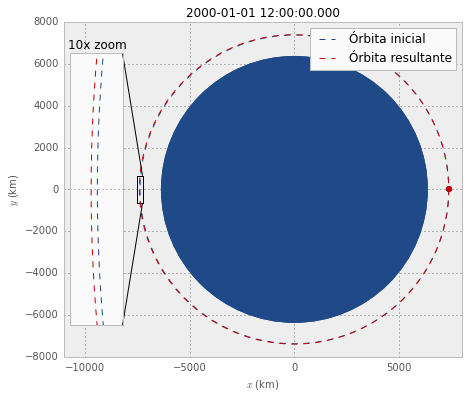

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

plt.style.use('pybonacci')

fig, ax = plt.subplots(figsize=(8, 6))
op = OrbitPlotter(ax)

_, l0 = op.plot(ss0)
l, l1 = op.plot(ss1)
l0.set_label("Órbita inicial")
l1.set_label("Órbita resultante")
ax.set_xlim(-11000, 8000)

leg = ax.legend()
leg.get_frame().set_facecolor('#fafafa')

ax_zoom = zoomed_inset_axes(ax, 10, loc=6, axes_kwargs={'axisbg': '#fafafa'})
op_zoom = OrbitPlotter(ax_zoom, num_points=1000)

op_zoom.plot(ss0)
op_zoom.plot(ss1)

ax_zoom.set_xlim(-ss1.r_a.to(u.km).value - 100, -ss1.r_a.to(u.km).value + 150)
ax_zoom.set_ylim(-650, 650)
ax_zoom.set_xticks([])
ax_zoom.set_yticks([0])
ax_zoom.set_yticklabels([])
ax_zoom.set_xlabel("")
ax_zoom.set_ylabel("")
ax_zoom.set_title("10x zoom")
mark_inset(ax, ax_zoom, 1, 4, fc='none')

plt.savefig("caso_a.png")

La predicción teórica para el semieje mayor de la nueva órbita es

$$a \sim \frac{r_0}{1 - 2 \frac{\delta v}{V_0}}$$

Comprobamos:

In [11]:
a_teorico = r0.to(u.km) / (1 - 2 * eps)
a_teorico

<Quantity 7392.921843687375 km>

In [12]:
ss1.a

<Quantity 7392.929251432115 km>

Ambos valores coinciden con un error relativo de una parte entre un millón:

In [13]:
(ss1.a - a_teorico) / ss1.a

<Quantity 1.0020040078645434e-06>

La máxima separación teórica es $d \sim 4 r_0 \frac{\delta v}{V_0}$.

In [14]:
d_teorica = 4 * r0.to(u.km) * eps
d_teorica

<Quantity 29.512544000000002 km>

In [15]:
d = ss1.r_a - ss0.r_a
d

<Quantity 29.58650286422926 km>

El error relativo es menor del $0.25\,\%$:

In [16]:
(d_teorica - d) / d

<Quantity -0.0024997501248677834>

La máxima diferencia de velocidades se dará en el apogeo. Ahora mismo los objetos `State` no me dan directamente las velocidades en perigeo y apogeo, así que se pueden calcular de dos formas:

* usando la ecuación de la energía $v_a = \sqrt{\frac{2\mu}{r_a} - \frac{\mu}{a}}$, o
* propagando la órbita hasta el apogeo (en este caso es fácil de calcular el tiempo porque será la mitad del período orbital) y calculando la velocidad del nuevo estado.

Vamos a comprobar ambas formas:

In [17]:
mu = ss1.attractor.k
va_energia = np.sqrt(2 * mu / ss1.r_a - mu / ss1.a)  # Esta operación respeta las unidades
va_energia

<Quantity 7.328099334769713 km / s>

<div class="alert alert-info">Lo bueno del segundo método es que da el **vector** velocidad.</div>

In [18]:
ss1_a = ss1.propagate(time_of_flight=ss1.period / 2)
va_prop = ss1_a.v
va_prop

<Quantity [ -2.55594980e-15, -7.32809933e+00, -0.00000000e+00] km / s>

¡Ambos valores son iguales hasta la precisión de la máquina!

In [19]:
(va_energia - norm(va_prop)) / va_energia

<Quantity 4.848069760659359e-16>

Finalmente comprobamos la diferencia de velocidades:

In [20]:
dv_teorica = 3 * eps
dv_teorica

0.003

In [21]:
(norm(V0) - norm(va_prop)) / norm(V0)

<Quantity 0.002998001998002307>

De nuevo la predicción teórica coincide con el resultado obtenido.

### *Caso b)*: Incremento $\delta v$ hacia el centro de la Tierra

Trabajamos de nuevo con un factor de proporcionalidad $\epsilon$

In [22]:
eps = 1 / 20.

Definimos el nuevo incremento de velocidad en la dirección del vector de posición inicial y sentido hacia la Tierra:

In [23]:
r_vec = ss0.r
dv = -r_vec / norm(r_vec) * norm(V0) * eps
dv

<Quantity [-0.36750675,-0.        ,-0.        ] km / s>

In [24]:
man2 = Maneuver.impulse(dv)
man2

In [25]:
ss2 = ss0.apply_maneuver(man2)
ss2.rv()

(<Quantity [ 7378.136,    0.   ,    0.   ] km>,
 <Quantity [-0.36750675, 7.35013505, 0.        ] km / s>)

De nuevo, la órbita resultante no será circular:

In [26]:
ss2.ecc

<Quantity 0.05>

Representamos ambas de nuevo para comprobar que el perigeo se ha desplazado.

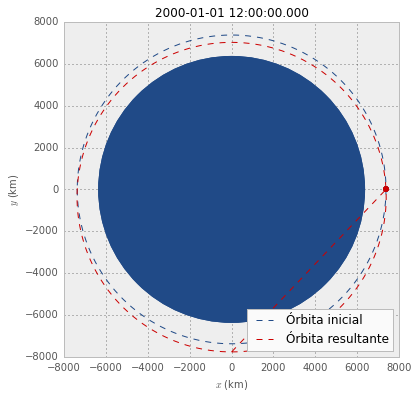

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
op = OrbitPlotter(ax, num_points=1000)

_, l0 = op.plot(ss0)
l, l2 = op.plot(ss2)
l0.set_label("Órbita inicial")
l2.set_label("Órbita resultante")

leg = ax.legend(loc=4)
leg.get_frame().set_facecolor('#fafafa')

plt.savefig("caso_b.png")